# Intro

## Statistical inference 
Using data from a sample to infer information about a population.

## Example 1
In a district of 10000 voters, we polled 100 people. 53 said they plan to vote for X, 40 said Y and 7 were undecided.

What is our best estimate of fraction of people in the population who are going to vote for X. 

What can we do to quantify the precision of that? E.g. 52 +- 2%


## Example 2
50 patients got a new pain-killer; 50 similar patients got an older drug. Mean self-reported pain scores were 4.1 for new drug and 4.5 for the old drug. 

How can we estimate the difference in the effect of the drugs?

How can we quantify the precision of that estimate?

Is it possible that the apparent difference is due to chance?

## Statistical inference

### Effect size
Usually a single number, ideally comparable across studies. The most important!

### Confidence interval (standard error)
Quantifies the precision of the estimate. Second important.

### p-value
Indicates whether the effect might be due to a chance. Distant third.

## New Stats book

The New Statistics: Estimation for better research - Cumming, G. (2012)
Movement for new statistics.

## The problem

Too many papers report p-values as if they were the most important part.

They do not care for the effect size.

In [31]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# some nice colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

%matplotlib inline

# 1. Effect size

## Part 1
To explore statistics that quantify effect size, we'll look at the difference in height between men and women. I used data from the Behavioral Risk Factor Surveillance System (BRFSS) to estimate the mean and standard deviation of height in cm for adult women and men in the U.S.

I'll use scipy.stats.norm to represent the distributions. The result is an rv object (which stands for random variable).

In [32]:
mu1, sig1 = 178, 7.7
male_height = scipy.stats.norm(mu1, sig1)
male_height

In [33]:
mu2, sig2 = 163, 7.3
female_height = scipy.stats.norm(mu2, sig2)

The following function evaluates the normal (Gaussian) probability density function (PDF) within 4 standard deviations of the mean. It takes and rv object and returns a pair of NumPy arrays.

In [34]:
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num * std, mean + num * std, 100)
    ys = rv.pdf(xs)
    return xs, ys

Here's what the two distributions look like.

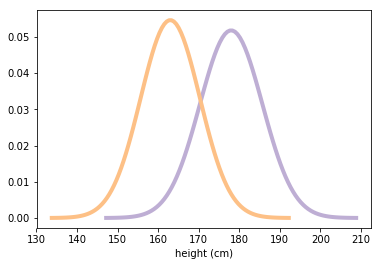

In [35]:
xs, ys = eval_pdf(male_height)
plt.plot(xs, ys, label="male", linewidth=4, color=COLOR2)

xs, ys = eval_pdf(female_height)
plt.plot(xs, ys, label="female", linewidth=4, color=COLOR3)
plt.xlabel("height (cm)")

Let's assume for now that those are the true distributions for the population.

I'll use rvs to generate random samples from the population distributions. Note that these are totally random, totally representative samples, with no measurement error!

In [36]:
male_sample = male_height.rvs(1000)

In [37]:
female_sample = female_height.rvs(1000)

Both samples are NumPy arrays. Now we can compute sample statistics like the mean and standard deviation.

In [38]:
mean1, std1 = male_sample.mean(), male_sample.std()
mean1, std1

(177.56888807492297, 7.8659142867037071)

The sample mean is close to the population mean, but not exact, as expected.

In [39]:
mean2, std2 = female_sample.mean(), female_sample.std()
mean2, std2

(163.26305357716521, 7.4828349324646393)

And the results are similar for the female sample.

Now, there are many ways to describe the magnitude of the difference between these distributions. An obvious one is the difference in the means.

In [40]:
difference_in_means = male_sample.mean() - female_sample.mean()
difference_in_means

14.305834497757758

On average, men are 14--15 centimeters taller. For some applications, that would be a good way to describe the difference, but there are a few problems:

Without knowing more about the distributions (like the standard deviations) it's hard to interpret whether a difference like 15 cm is a lot or not.

The magnitude of the difference depends on the units of measure, making it hard to compare across different studies.

There are a number of ways to quantify the difference between distributions. A simple option is to express the difference as a percentage of the mean.

In [41]:
difference_in_means / male_sample.mean()

0.080564983274105939

Why the male mean in the denominator? We could use any average. 

Obvious measure of effect size is difference in means, which is in cm.

Relative difference, as a percentage, might be useful, but you might have to choose the denominator.

Cohen's `d` is a symmetric and standardized, so comparable across studies.

## Part 2

An alternative way to express the difference between distributions is to see how much they overlap. To define overlap, we choose a threshold between the two means. The simple threshold is the midpoint between the means.

In [42]:
simple_thresh = (mean1 + mean2) / 2
simple_thresh

170.41597082604409

A better, but slightly more complicated threshold is the place where the PDFs cross.

In [43]:
thresh = (std1 * mean2 + std2 * mean1) / (std1 + std2)
thresh

170.23744586081733

In this example, there's not much difference between the two thresholds.

Now we can count how many men are below the threshold.

In [44]:
male_below_thresh = sum(male_sample < thresh)
male_below_thresh

179

And how many women are above it.

In [45]:
female_above_thresh = sum(female_sample > thresh)
female_above_thresh

182

The "overlap" is the area under the curves that ends up on the wrong side of the threshold.

In [46]:
male_overlap = male_below_thresh / len(male_sample)
female_overlap = female_above_thresh / len(female_sample)
male_overlap, female_overlap

(0.17899999999999999, 0.182)

In practical terms, you might report the fraction of people who would be misclassified if you tried to use height to guess sex, which is the average of the male and female overlap rates.

In [48]:
misclassification_rate = (male_overlap + female_overlap) / 2
misclassification_rate

0.18049999999999999

Another way to quantify the difference between distributions is what's called "probability of superiority", which is a problematic term, but in this context it's the probability that a randomly-chosen man is taller than a randomly-chosen woman.

Suppose I choose a man and a woman at random. What is the probability that the man is taller?

In [55]:
(male_sample > female_sample).mean()

0.89900000000000002

In [57]:
(male_sample > female_sample).sum() / len(male_sample)

0.89900000000000002

Overlap (or misclassification rate) and "probability of superiority" have two good properties:

* As probabilities, they don't depend on units of measure, so they are comparable between studies.

* They are expressed in operational terms, so a reader has a sense of what practical effect the difference makes.

## Part 3 - Cohen's d effect size

There is one other common way to express the difference between distributions.  Cohen's $d$ is the difference in means, standardized by dividing by the standard deviation.  Here's the math notation:

$ d = \frac{\bar{x}_1 - \bar{x}_2} s $

where $s$ is the pooled standard deviation:

$s = \sqrt{\frac{n_1 s^2_1 + n_2 s^2_2}{n_1+n_2}}$

Here's a function that computes it.


In [58]:
def cohen_effect_size(group1, group2):
    """Compute Cohen's d.
    
    group1: Series or NumPy array
    group2: Series or NumPy array
    
    returns: float
    """
    diff = group1.mean() - group2.mean()
    
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

Computing the denominator is a little complicated; in fact, people have proposed several ways to do it. This implementation uses the "pooled standard deviation", which is a weighted average of the standard deviations of the two groups.

And here's the result for the difference in height between men and women.

In [59]:
cohen_effect_size(male_sample, female_sample)

1.8635239506126453

Most people don't have a good sense of how big  d=1.9d=1.9  is, so let's make a visualization to get calibrated.


In [60]:
def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = (treatment_sample > control_sample).mean()
    return overlap, superiority

Here's the function that takes Cohen's  dd , plots normal distributions with the given effect size, and prints their overlap and superiority.

In [69]:
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = scipy.stats.norm(0, 1)
    treatment = scipy.stats.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    plt.fill_between(xs, ys, label='control', color=COLOR3, alpha=0.7)

    xs, ys = eval_pdf(treatment)
    plt.fill_between(xs, ys, label='treatment', color=COLOR2, alpha=0.7)
    
    o, s = overlap_superiority(control, treatment)
    plt.text(0, 0.05, 'overlap ' + str(o))
    plt.text(0, 0.15, 'superiority ' + str(s))
    plt.show()
    #print('overlap', o)
    #print('superiority', s)

Here's an example that demonstrates the function.

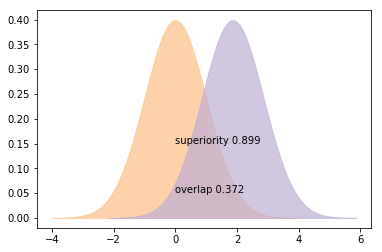

In [74]:
plot_pdfs(1.86)

Cohen's $d$ has a few nice properties:

* Because mean and standard deviation have the same units, their ratio is dimensionless, so we can compare $d$ across different studies.

* In fields that commonly use $d$, people are calibrated to know what values should be considered big, surprising, or important.

* Given $d$ (and the assumption that the distributions are normal), you can compute overlap, superiority, and related statistics.

In summary, the best way to report effect size depends on the audience and your goals.  There is often a tradeoff between summary statistics that have good technical properties and statistics that are meaningful to a general audience.

Cohen's d is symmetric and standardized, so comparable across studies.

It has no units.

With it you can compute relevant statistics.

## Summary

Rule 1: Choose a measure of effect size that is meaningful in context.

Rule 2: The estimated effect size is the most important result. Everything else is auxiliary.

Standardized measures are comparable across studies (but sometimes violate Rule 1).


# 2. Quantifying precision

We will talk about standard errors and confidence intervals here.

## Three kinds of error

* Sampling bias (hard to quantify the error): Ideally the sample should be representative. If some groups are oversampled, there should be no relationship between group membership and what you measure.

* Measurement error (sometimes quantifable)

* Random error (relatively easy to quantify): Even for large samples, each possible sample yields different measurements.

Ususally to discuss the first two qualitatively, and quantify the third.

## Part 1

Suppose we want to estimate the average weight of men and women in the U.S.

And we want to quantify the uncertainty of the estimate.

One approach is to simulate many experiments and see how much the results vary from one experiment to the next.

I'll start with the unrealistic assumption that we know the actual distribution of weights in the population.  Then I'll show how to solve the problem without that assumption.

Based on data from the [BRFSS](http://www.cdc.gov/brfss/), I found that the distribution of weight in kg for women in the U.S. is well modeled by a lognormal distribution with the following parameters.

In [75]:
weight = scipy.stats.lognorm(0.23, 0, 70.8)
weight.mean(), weight.std()

(72.697645732966876, 16.944043048498038)

Here's what that distribution looks like.

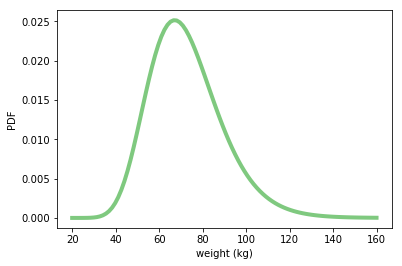

In [76]:
xs = np.linspace(20, 160, 100)
ys = weight.pdf(xs)
plt.plot(xs, ys, linewidth=4, color=COLOR1)
plt.xlabel("weight (kg)")
plt.ylabel("PDF")

make_sample draws a random sample from this distribution. The result is a NumPy array.

In [77]:
def make_sample(n=100):
    sample = weight.rvs(n)
    return sample

Here's an example with n=100. The mean and std of the sample are close to the mean and std of the population, but not exact.

In [78]:
sample = make_sample(n=100)
sample.mean(), sample.std()

(73.203650942403641, 17.176386248276859)

We want to estimate the average weight in the population, so the "sample statistic" we'll use is the mean.

In [79]:
def sample_stat(sample):
    return sample.mean()

One iteration of "the experiment" is to collect a sample of 100 women and compute their average weight.

We can simulate running this experiment many times, and collect a list of sample statistics. The result is a NumPy array.

In [86]:
def compute_sampling_distribution(n=100, iters=1000):
    stats = [sample_stat(make_sample(n)) for i in range(iters)]
    return np.array(stats)

The next line runs the simulation 1000 times and puts the results in sample_means.

In [87]:
sample_means = compute_sampling_distribution(n=100, iters=1000)